In [2]:
import time
import json
from data_crawler import data_crawler


# { period : [ limit, milliseconds ] } (limit <= 200)
supported_period = { "1H" : [ 100, 3600000 ],
                     "6H" : [ 100, 21600000 ],
                     "1D" : [ 100 ,86400000 ]}

# { period : [ datas, lasttime ] }
download_format = { "1H" : [ None, None ],
                    "6H" : [ None, None ],
                    "1D" : [ None, None ] }  

supported_ticker = { "BTCUSDT_UMCBL" }
ticker = "BTCUSDT_UMCBL"

data_crawler = data_crawler(None, supported_ticker, supported_period, download_format, None)

datas = data_crawler.get_downloaded_datas()[ticker]

for period in download_format.keys():
    data = datas[period][0]
    print(period, type(data), len(data))
    print(data[-3:])
    
# [ 'timestamp in milliseconds', 'Opening price', 'Highest price', 'Lowest price', 'Close price',
#   'Base currency trading volume', `Quote currency trading volume` ]

1H <class 'list'> 100
[[1696258800000.0, 28300.8, 28409.0, 27985.0, 28032.8, 7646.61, 215570160.8384], [1696262400000.0, 28032.8, 28119.5, 27847.3, 28000.1, 7945.282, 222450416.0084], [1696266000000.0, 28000.1, 28038.9, 27901.3, 27927.5, 956.275, 26731888.6509]]
6H <class 'list'> 100
[[1696219200000.0, 28121.9, 28483.4, 27926.1, 28281.3, 31146.058, 879394565.9401], [1696240800000.0, 28281.3, 28598.8, 27985.0, 28032.8, 33039.826, 935127190.3912], [1696262400000.0, 28032.8, 28119.5, 27847.3, 27927.6, 8901.624, 249184175.8085]]
1D <class 'list'> 100
[[1696089600000.0, 26992.5, 27287.8, 26941.6, 27148.6, 37354.426, 1012443504.4359], [1696176000000.0, 27148.6, 28598.8, 27026.2, 28032.8, 106370.971, 2985349312.4028], [1696262400000.0, 28032.8, 28119.5, 27847.3, 27927.5, 8901.557, 249182304.6593]]


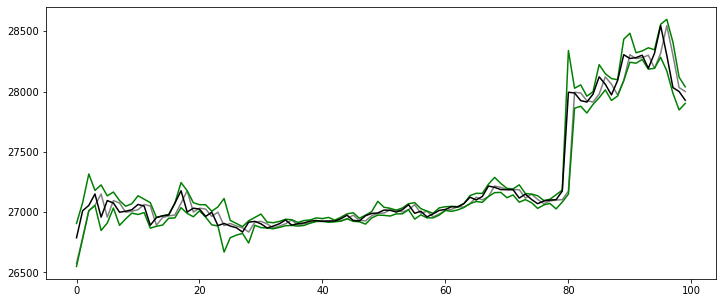

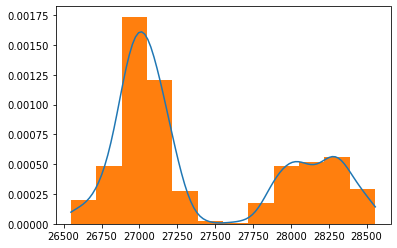

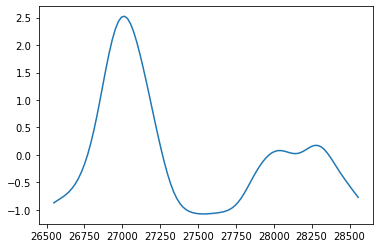

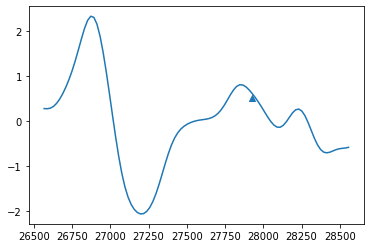

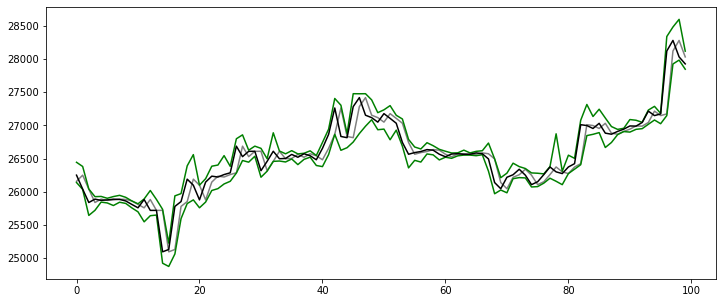

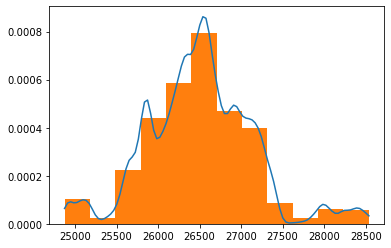

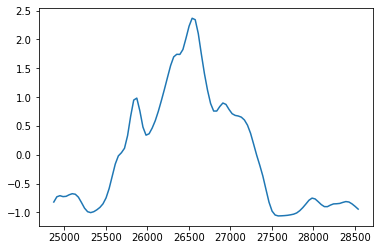

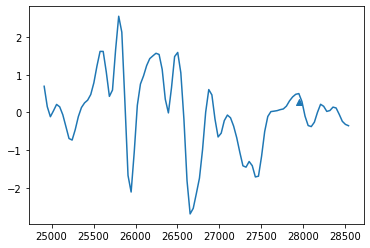

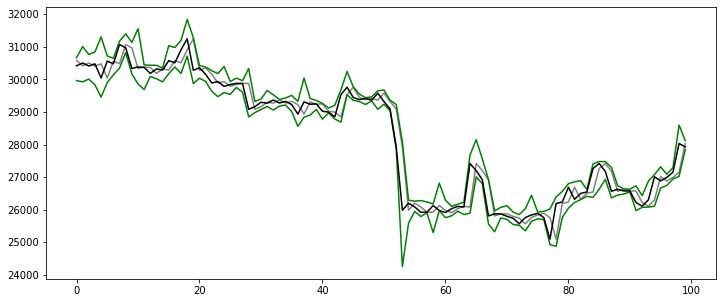

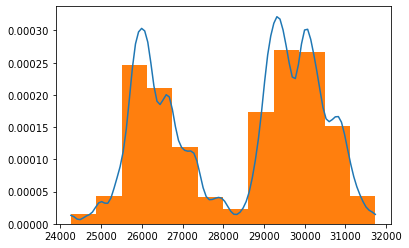

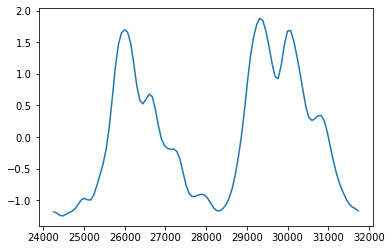

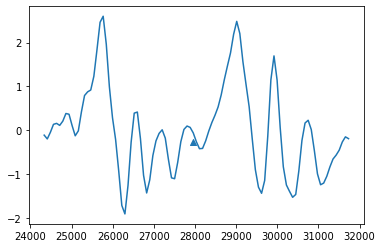

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
%matplotlib inline

for period in supported_period.keys():
    
    # 데이터 Pandas 변환
    datas_ = datas[period][0]
    datas_ = pd.DataFrame(datas_, columns=['time', 'open', 'high', 'low', 'close', 'volume', 'q_volume'])
    
    # 거래량 multiple 계산 방식 구현
    volume_profiles = []
    
    for i in range(len(datas_['time'])):
        volume = datas_['volume'][i]
        open_price = datas_['open'][i]
        high_price = datas_['high'][i]
        low_price = datas_['low'][i]
        close_price = datas_['close'][i]
        center_price = (open_price + high_price + low_price + close_price) / 4
        
        total_div = 10
        div_size = (high_price - low_price) / total_div
        index_pivot = (center_price - low_price) // div_size
        index_pivot = max(min(index_pivot, total_div - 1), 1) # 시고저종 가격을 바탕으로 중심값 선정
        multiple_of_volume = np.array(list(np.linspace(1, 0, int(index_pivot))) \
                                    + list(np.linspace(0, 1, int(total_div - index_pivot + 1))[1:]))
        multiple_of_volume /= sum(multiple_of_volume)
        
        for j in range(len(multiple_of_volume)):
            for k in range(int(volume * multiple_of_volume[j] / total_div)):
                volume_profiles.append(low_price + j * div_size)

    # 주가 그래프 그리기
    plt.figure(figsize=(12,5))
    plt.plot(datas_['open'], 'gray')
    plt.plot(datas_['high'], 'green')
    plt.plot(datas_['low'], 'green')
    plt.plot(datas_['close'], 'black')
    plt.show()
    
    # KDE 적용
    level = 100
    x = np.linspace(min(volume_profiles) - 1, max(volume_profiles) + 1, level)
    kde = gaussian_kde(volume_profiles)
    plt.plot(x, kde(x), label='KDE')
    plt.hist(volume_profiles, density=True, bins=12)
    plt.show()
    
    # KDE 정규화 적용
    kdes = []
    
    for i in range(len(x)):
        kdes.append(kde(x[i]))
    
    kdes = np.array(kdes)
    kdes -= np.mean(kdes)
    kdes /= np.std(kdes)
    
    plt.plot(x, kdes, label='KDE Normalization')
    plt.show()
    
    # 미분 적용
    kdes_diff = []

    for i in range(1, len(x)):
        kdes_diff.append(kde(x[i]) - kde(x[i-1]))
    
    kdes_diff = np.array(kdes_diff)
    kdes_diff -= np.mean(kdes_diff)
    kdes_diff /= np.std(kdes_diff)
    
    plt.plot(x[1:], kdes_diff, label='KDE Differential')
    
    # 현재 가격에 대한 plot 적용
    now_close = datas_['close'].iloc[-1]
    for idx, i in enumerate(x):
        if now_close <= i:
            plt.scatter(i, kdes_diff[idx], marker='^')
            break
    
    
    plt.show()
    

# 1H
rsi14
95    78.681941
96    65.324937
97    54.460511
98    53.295799
99    50.703142
Name: rsi14, dtype: float64
rsi14_ma
95    78.510358
96    77.310515
97    75.399715
98    73.320587
99    70.891688
Name: rsi14_ma, dtype: float64


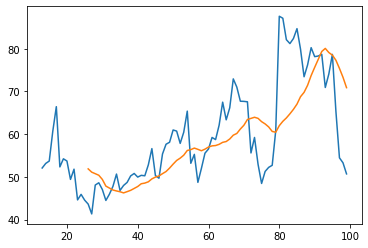

macd
95    301.534390
96    289.081456
97    254.661918
98    222.185502
99    188.419946
Name: macd, dtype: float64
macd_ma
95    287.689660
96    290.800003
97    289.401683
98    282.301254
99    270.450971
Name: macd_ma, dtype: float64


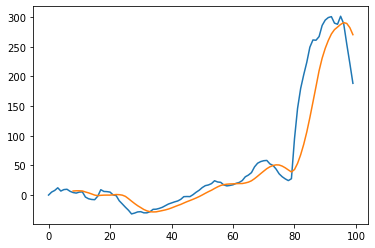

macd_gc_prob
95    0.177337
96    0.000000
97    0.000000
98    0.000000
99    0.000000
Name: macd_gc_prob, dtype: float64


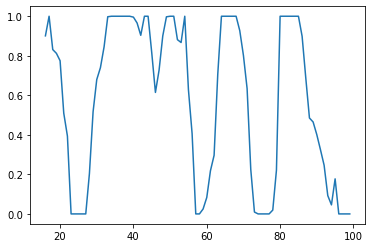

# 6H
rsi14
95    66.685316
96    82.206000
97    83.590330
98    73.933588
99    70.234464
Name: rsi14, dtype: float64
rsi14_ma
95    64.517910
96    65.574718
97    66.767760
98    67.407068
99    67.654228
Name: rsi14_ma, dtype: float64


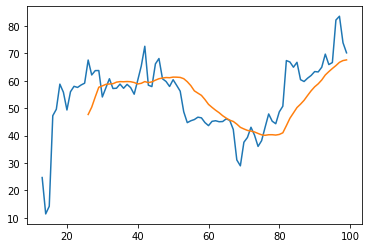

macd
95    171.989230
96    249.382685
97    319.885405
98    351.662239
99    364.162180
Name: macd, dtype: float64
macd_ma
95    141.566083
96    156.802970
97    179.098529
98    204.167592
99    229.765006
Name: macd_ma, dtype: float64


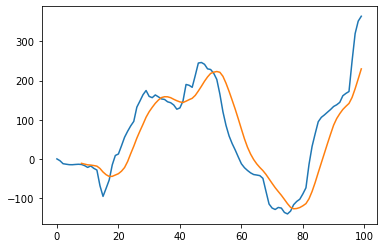

macd_gc_prob
95    0.310802
96    1.000000
97    1.000000
98    1.000000
99    0.911200
Name: macd_gc_prob, dtype: float64


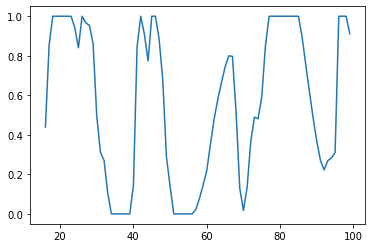

# 1D
rsi14
95    54.100796
96    55.434755
97    57.360122
98    66.253689
99    64.527581
Name: rsi14, dtype: float64
rsi14_ma
95    51.584771
96    51.922326
97    52.361965
98    52.876133
99    53.160837
Name: rsi14_ma, dtype: float64


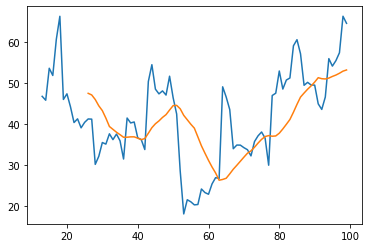

macd
95     16.883556
96     47.417327
97     83.245521
98    180.869449
99    246.897226
Name: macd, dtype: float64
macd_ma
95    -1.815507
96    -0.086427
97     5.886067
98    23.414475
99    48.874532
Name: macd_ma, dtype: float64


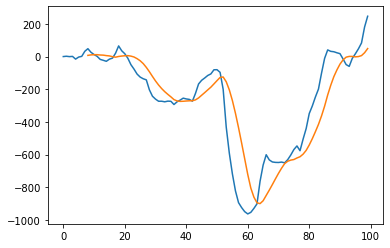

macd_gc_prob
95    0.296888
96    0.507618
97    0.833577
98    1.000000
99    1.000000
Name: macd_gc_prob, dtype: float64


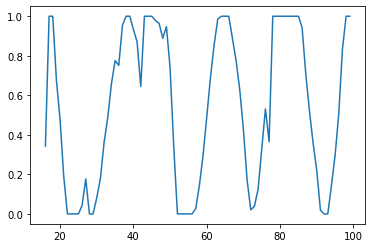

In [19]:
# RSI 보조지표 계산
datas__ = {}

for period in supported_period.keys():
    datas_ = datas[period][0]
    datas_ = pd.DataFrame(datas_, columns=['time', 'open', 'high', 'low', 'close', 'volume', 'q_volume'])
    
    # 상승과 하락에 대한 차이 계산
    datas_['price_diff'] = datas_['close'].diff()
    
    # 양수(상승)와 음수(하락)를 구분하는 열 추가
    datas_['gain'] = datas_['price_diff'].apply(lambda x: x if x > 0 else 0)
    datas_['loss'] = datas_['price_diff'].apply(lambda x: -x if x < 0 else 0)
    
    # 이동평균 계산 (14일 기간)
    p = 14
    datas_['au'] = datas_['gain'].ewm(com=p-1, min_periods=p).mean()
    datas_['ad'] = datas_['loss'].ewm(com=p-1, min_periods=p).mean()
    datas_['rs'] = datas_['au'] / datas_['ad']
    
    # 상대강도지수 계산 (RSI)
    datas_['rsi14'] = 100 - (100 / (1 + datas_['rs']))
    
    # 14일 동안의 rsi14 에 대한 평균선 계산
    datas_['rsi14_ma'] = datas_['rsi14'].rolling(window=14).mean()
    
    # 단기(12일) 이동평균 계산
    datas_['ema12'] = datas_['close'].ewm(span=12).mean()

    # 장기(26일) 이동평균 계산
    datas_['ema26'] = datas_['close'].ewm(span=26).mean()

    # MACD 계산
    datas_['macd'] = datas_['ema12'] - datas_['ema26']
    
    # 9일 동안의 macd 에 대한 평균선 계산
    datas_['macd_ma'] = datas_['macd'].rolling(window=9).mean()
    
    # MACD Osillator 계산
    datas_['macd_oscillator'] = datas_['macd'] - datas_['macd_ma']
    
    # MACD Osillator 골든크로스 확률 계산 (대략적인)
    datas_['macd_min'] = datas_['macd_oscillator'].rolling(window=9).min()
    datas_.loc[datas_['macd_min'] > 0, 'macd_min'] = 0
    datas_['macd_max'] = datas_['macd_oscillator'].rolling(window=9).max()
    datas_.loc[datas_['macd_max'] < 0, 'macd_max'] = 0
    
    datas_['macd_gc_prob'] = (datas_['macd_oscillator'] - datas_['macd_min']) \
                           / (datas_['macd_max'] - datas_['macd_min'])
    
    # 필요 없는 열 삭제
    datas_.drop(['price_diff', 'gain', 'loss', 'au', 'ad', 'rs', 'macd_oscillator', 'macd_min', 'macd_max'], axis=1, inplace=True)

    datas__[period] = datas_
    
    print("#", period)
    print("rsi14")
    print(datas_["rsi14"].iloc[-5:])
    print("rsi14_ma")
    print(datas_["rsi14_ma"].iloc[-5:])
    plt.plot(datas_["rsi14"])
    plt.plot(datas_["rsi14_ma"])
    plt.show()
    
    print("macd")
    print(datas_["macd"].iloc[-5:])
    print("macd_ma")
    print(datas_["macd_ma"].iloc[-5:])
    plt.plot(datas_["macd"])
    plt.plot(datas_["macd_ma"])
    plt.show()
    
    print("macd_gc_prob")
    print(datas_["macd_gc_prob"].iloc[-5:])
    plt.plot(datas_["macd_gc_prob"])
    plt.show()


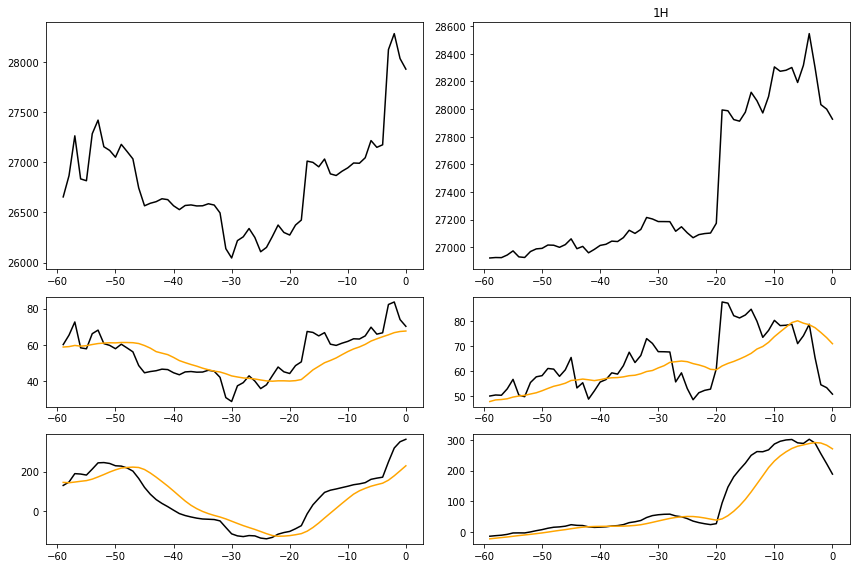

imgs\2023-10-03_02-35-51.png


In [39]:
import os

def draw_graph(datas_, period, longer_period, resistance_lines, support_lines, debug=False):
    fig = plt.figure(figsize=(12,8))
    x = np.arange(-59, 1)

    # price
    ax1 = plt.subplot2grid((4,2), (0,0), rowspan=2, fig=fig)
    ax2 = plt.subplot2grid((4,2), (0,1), rowspan=2, fig=fig)
    ax1.plot(x, datas_[longer_period]['close'].iloc[-60:], color='black')
    ax2.plot(x, datas_[period]['close'].iloc[-60:], color='black')
    plt.title(period)
    
    # support and resistnace lines
    for resistance_line  in resistance_lines:
        ax1.plot(x, [ resistance_line for _ in range(len(x)) ], color='purple')
        ax2.plot(x, [ resistance_line for _ in range(len(x)) ], color='purple')
        
    for support_line in support_lines:
        ax1.plot(x, [ support_line for _ in range(len(x)) ], color='green')
        ax2.plot(x, [ support_line for _ in range(len(x)) ], color='green')

    # rsi
    ax3 = plt.subplot2grid((4,2), (2,0), fig=fig)
    ax4 = plt.subplot2grid((4,2), (2,1), fig=fig)
    ax3.plot(x, datas_[longer_period]['rsi14'].iloc[-60:], color='black')
    ax3.plot(x, datas_[longer_period]['rsi14_ma'].iloc[-60:], color='orange')
    ax4.plot(x, datas_[period]['rsi14'].iloc[-60:], color='black')
    ax4.plot(x, datas_[period]['rsi14_ma'].iloc[-60:], color='orange')
    
    # macd
    ax5 = plt.subplot2grid((4,2), (3,0), fig=fig)
    ax6 = plt.subplot2grid((4,2), (3,1), fig=fig)
    ax5.plot(x, datas_[longer_period]['macd'].iloc[-60:], color='black')
    ax5.plot(x, datas_[longer_period]['macd_ma'].iloc[-60:], color='orange')
    ax6.plot(x, datas_[period]['macd'].iloc[-60:], color='black')
    ax6.plot(x, datas_[period]['macd_ma'].iloc[-60:], color='orange')
    
    current_time = time.strftime("%Y-%m-%d_%H-%M-%S")  # 원하는 포맷으로 지정
    png_file_path = os.path.join("imgs", f"{current_time}.png")
    
    plt.tight_layout()
    plt.savefig(png_file_path, dpi=160)
    
    if debug is True:
        plt.show()
    
    return png_file_path
    
png_file_path = draw_graph(datas__, "1H", "6H", [], [], True)
print(png_file_path)